In [12]:
import numpy as np 
from scipy.spatial.distance import cdist   
from matplotlib import pyplot as plt 

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1 

change the code below to make the data distribution of x closer to this image

<img src="upperleft.png" height=500 width=500>

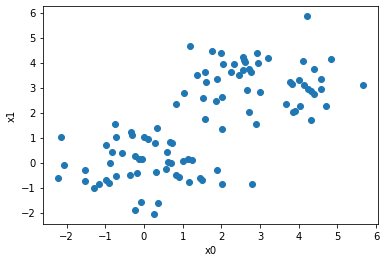

In [110]:
# Question 1:

pts = 50

rng = np.random.default_rng()

a = rng.multivariate_normal(
    mean=[3,3], 
    cov=[[1,0],
         [0,1]], 
    size=pts,
)

b = rng.multivariate_normal(
    mean=[0,0], 
    cov=[[1,0],
         [0,1]], 
    size=pts,
)

x = np.concatenate((a, b))

# Plot data 
plt.scatter(x[:, 0], x[:, 1])
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

# Question 2

Fix the bug in this k-mean clustering function, then plot the resulting color labeled clusters like this

<img src="Q2.png" height=500 width=500>

and lastly edit the function's docstrings and comments to make the type of input arguments expected more clear as well as the algorithm readable like pseudocode

In [ ]:
# Question 2:

def kmeans(x, k, no_of_iterations):  
    
    """ Function to implement k-means clustering 
    # x is a (num_samples, 2) numpy array 
    # k is number of clusters 
    # no_of_iterations is the number of iterations to run k means
    """
    
    idx = np.random.choice(len(x), k, replace=False)     
    #Randomly choosing Centroids     
    
    centroids = x[idx, :]       
    distances = cdist(x, centroids ,'euclidean')          
    points = np.array([np.argmax(i) for i in distances])  
    
    for _ in range(no_of_iterations):  
        
        centroids = []      
        
        for idx in range(k):     
            
            temp_cent = x[points==idx].mean(axis=1)   
            centroids.append(temp_cent) 
            centroids = np.vstack(centroids)  
            distances = cdist(x, centroids ,'euclidean')    
            
        points = np.array([np.argmax(i) for i in distances])              
            
    return points

points = kmeans(x,k=2,no_of_iterations=10)

cluster1 = x[points==0]
cluster2 = x[points==1]

# Plot data 
plt.scatter(cluster1[:, 0], cluster1[:, 1])
plt.scatter(cluster2[:, 0], cluster2[:, 1])
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

# Question 3

In [4]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train.shuffle().select(range(50000)),
        "valid": ds_valid.shuffle().select(range(500))
    }
)

raw_datasets

Using custom data configuration huggingface-course--codeparrot-ds-train-a9b1bc4c2b855d04


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /Users/carson/.cache/huggingface/datasets/huggingface-course___json/huggingface-course--codeparrot-ds-train-a9b1bc4c2b855d04/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


Using custom data configuration huggingface-course--codeparrot-ds-valid-e5ece22bd7b6a6ac


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /Users/carson/.cache/huggingface/datasets/huggingface-course___json/huggingface-course--codeparrot-ds-valid-e5ece22bd7b6a6ac/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 50000
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 500
    })
})

In [8]:
print(raw_datasets["train"][0].keys())
print(" ")
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

dict_keys(['repo_name', 'path', 'copies', 'size', 'content', 'license'])
 
REPO_NAME: dvro/imbalanced-learn
PATH: imblearn/under_sampling/tests/test_allknn.py
COPIES: 2
SIZE: 9960
CONTENT: """Test the module repeated edited nearest neighbour."""
from __future__ import print_function

import os

import numpy as np
from numpy.testing import assert_raises
from numpy.testing import assert_e
LICENSE: mit


In [11]:
print(raw_datasets["train"][0]["content"][:200])

"""Test the module repeated edited nearest neighbour."""
from __future__ import print_function

import os

import numpy as np
from numpy.testing import assert_raises
from numpy.testing import assert_e


In [13]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Downloading:   0%|          | 0.00/265 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/771k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Input IDs length: 46
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 25, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 109]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
outputs = tokenizer(
    raw_datasets["train"][:1]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 28
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 25]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
outputs = tokenizer(
    raw_datasets["train"][:3]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 68
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 25, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 109, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 101]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [17]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)

tokenized_datasets

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 1371130
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 13166
    })
})

In [19]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


In [30]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

out = data_collator([tokenized_datasets["train"][i] for i in range(5)])

for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


In [31]:
out["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [32]:
keytoken_ids = []
for keyword in [
    "plt",
    "pd",
    "sk",
    "fit",
    "predict",
    " plt",
    " pd",
    " sk",
    " fit",
    " predict",
    "testtest",
]:
    ids = tokenizer([keyword]).input_ids[0]
    if len(ids) == 1:
        keytoken_ids.append(ids[0])
    else:
        print(f"Keyword has not single token: {keyword}")

Keyword has not single token: testtest


In [33]:
keytoken_ids

[8436, 4289, 1201, 2770, 5431, 2564, 2604, 2110, 2872, 4969]

In [34]:
from torch.nn import CrossEntropyLoss
import torch


def keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    # Calculate and scale weighting
    weights = torch.stack([(inputs == kt).float() for kt in keytoken_ids]).sum(
        axis=[0, 2]
    )
    weights = alpha * (1.0 + weights)
    # Calculate weighted average
    weighted_loss = (loss_per_sample * weights).mean()
    return weighted_loss

In [39]:
from torch.utils.data.dataloader import DataLoader

tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
eval_dataloader = DataLoader(tokenized_datasets["valid"], batch_size=32)

In [40]:
weight_decay = 0.1


def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]

In [41]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])

        losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()

In [42]:
from torch.optim import AdamW

optimizer = AdamW(get_grouped_params(model), lr=5e-4)

In [44]:
from accelerate import Accelerator

accelerator = Accelerator(fp16=True)

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

/Users/carson/projects/buddy/env_ds/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/Users/carson/projects/buddy/env_ds/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [45]:
from transformers import get_scheduler

num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)
print(num_update_steps_per_epoch)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
print(num_training_steps)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)

42848
42848


In [ ]:
eval_loss, perplexity = evaluate()
print(eval_loss, perplexity)

In [ ]:
from tqdm.notebook import tqdm

gradient_accumulation_steps = 8
eval_steps = 5_000

model.train()
completed_steps = 0
for epoch in range(num_train_epochs):
    for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=num_training_steps
    ):
        logits = model(batch["input_ids"]).logits
        loss = keytoken_weighted_loss(batch["input_ids"], logits, keytoken_ids)
        if step % 100 == 0:
            accelerator.print(
                {
                    "lr": get_lr(),
                    "samples": step * samples_per_step,
                    "steps": completed_steps,
                    "loss/train": loss.item() * gradient_accumulation_steps,
                }
            )
        loss = loss / gradient_accumulation_steps
        accelerator.backward(loss)
        if step % gradient_accumulation_steps == 0:
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1
        if (step % (eval_steps * gradient_accumulation_steps)) == 0:
            eval_loss, perplexity = evaluate()
            accelerator.print({"loss/eval": eval_loss, "perplexity": perplexity})
            model.train()
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
            if accelerator.is_main_process:
                tokenizer.save_pretrained(output_dir)
                repo.push_to_hub(
                    commit_message=f"Training in progress step {step}", blocking=False
                )